# Projet Data Science

Ce projet a pour but de proposer des modèles de classification supervisée d'assertions faites par des figures politique selon leurs veracités. Autrement dit, nous devons proposer une approche automatique de fact-checking.
    
## Auteurs

👨‍🎓 CANTA Thomas (thomas.canta@etu.umontpellier.fr)  
👨‍🎓 DESGENETEZ Charles (charles.desgenetez@etu.umontpellier.fr)  
👨‍🎓 FONTAINE Quentin (quentin.fontaine02@etu.umontpellier.fr)  
👨‍🎓 REITER Maxime (maxime.reiter@etu.umontpellier.fr)  

Ce projet est réalisé dans le cadre de l'UE HMIN232M du Master 1 AIGLE de l'université de Montpellier, année 2020/2021.

# 0 - Mise en place de Google Drive et de fonctions

Le bout de code ci-dessous est optionnelle et permet de se connecter à notre google drive afin d'accéder aux données à traiter. Vous pourrez dans l'étape suivante choisir une méthode local si vous le souhaiter.

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initialisation de fonctions globales qui serviront tout le long de notre étude.

In [48]:
import seaborn as sn
import matplotlib.pyplot as plt

def display_barplot(df, title, x, xlabel, y, ylabel, orient):
  """
  Display a barplot
  @param df, the dataframe
  @param title, the title of the figure
  @param x, the x axe values
  @param xlabel, the x axe label
  @param y, the y axe values
  @param ylabel, the y axe label
  @param orient, the barplot orientation (h || v)
  """
  
  # --- Colors
  colors = sn.color_palette('Reds_d', n_colors=len(df))

  # --- Barplot
  plt.figure(figsize=(15,5))
  g = sn.barplot(x=x, y=y,
             palette = colors,
             data=df, 
             orient=orient)

  # --- Annotations
  for p in g.patches:
    if orient == 'v':
      g.annotate('{:.2f}'.format(
          p.get_height()), 
          (p.get_x()+0.4, p.get_height()),
          ha='center', va='bottom',
          color= 'black')
    else:
      g.annotate('{:.2f}'.format(
          p.get_width()), 
          (p.get_width()+0.02, p.get_y()+0.4),
          ha='left', va='center',
          color='black')
    
  # --- Cosmetic
  plt.title(title, size=18)
  plt.xlabel(xlabel, size=15)
  plt.ylabel(ylabel, size=15)
  sn.despine()

def to_percent(n):
  """
  Use to increase the readability of the code
  @param n: (number) The number to convert
  @return n: (number) The number converted
  """
  return n*100

# 1 - Extraction des données 

Le fichier d'origine étant trop volumineux, aucun de nous n'était en mesure de l'ouvrir sans que l'ordinateur ne plante. 

Pour pallier à ce problème nous avons récupérer les différents *Truth rating* ( True, False, Mixture ) un à un et de les concaténer en un dataframe via [data.gesis.org](https://data.gesis.org/claimskg/explorer/home).

In [238]:
import pandas as pandas
import glob, os 

# Méthode locale
# df = pandas.concat( map( pandas.read_csv, glob.glob(os.path.join('', "./datasets/*.csv"))))

# Méthode drive
df = pandas.concat( map( pandas.read_csv, glob.glob(os.path.join('', "/content/drive/My Drive/Colab Notebooks/datasets/*.csv"))))

row, col = df.shape
print("Dataframe size: " + str(df.size))
df.head()

Dataframe size: 342328


,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language
0,http://data.gesis.org/claimskg/claim_review/36...,'There will be no public funding for abortion ...,2010-03-21,3,True,Bart Stupak,Stupak revises abortion stance on health care ...,"Abortion rights,Barack Obama,Bart Stupak,Ben N...",abortion,"Abortion,Health Care",politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English
1,http://data.gesis.org/claimskg/claim_review/e6...,Central Health 'is the only hospital district ...,2011-03-15,3,True,Wayne Christian,State Rep. Wayne Christian says Central Health...,"Austin American-Statesman,Harris County Hospit...",NaN,Abortion,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English
2,http://data.gesis.org/claimskg/claim_review/e0...,Says most of Perry's chiefs of staff have been...,2010-08-14,3,True,Bill White,Bill White says most of Gov. Rick Perry's chie...,"AT&T,Bill Clements,Bill White,Bracewell & Giul...",NaN,Ethics,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English
3,http://data.gesis.org/claimskg/claim_review/48...,Says 'as Co-Chair of the Joint Ways & Means Co...,2012-09-28,3,True,Mary Nolan,Did Mary Nolan secure funding for Milwaukie br...,"Carolyn Tomei,Dave Hunt,Fetsch,Jeff Merkley,Ka...",Portland-Milwaukie Light Rail project,"State Budget,State Finances,Transportation",politifact,http://www.politifact.com,http://www.politifact.com/oregon/statements/20...,English
4,http://data.gesis.org/claimskg/claim_review/80...,Says Gary Farmer’s claim that he 'received an ...,2016-07-08,3,True,Jim Waldman,Florida Senate candidate never actually receiv...,"Gary Farmer,Gwyndolen Clarke-Reed,Jim Waldman,...",Gary Farmer,Guns,politifact,http://www.politifact.com,http://www.politifact.com/florida/statements/2...,English


Analysons les données nulles présentes dans notre dataframe

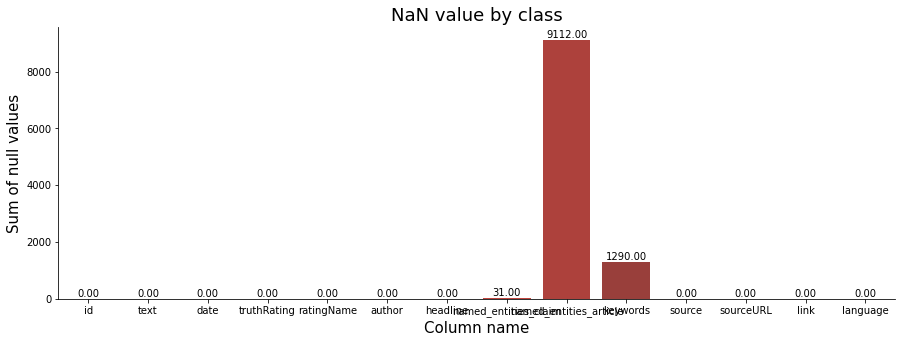

In [239]:
null_sums = [df[column].isnull().sum() for column in df.columns]

sums_df = pandas.DataFrame({
    'Columns': df.columns, 
    'Null_sums': null_sums})

display_barplot(sums_df, 'NaN value by class', 
                'Columns', 'Column name', 
                'Null_sums', 'Sum of null values',
                'v')

La donnée principal, *text*, ne comporte aucune cellule nulle, ce qui veut dire que nous pouvons remplacer les autres cellules nulles en une chaîne de caractères vide. Nous pouvons nous le permettre car ce sont des données additionnels que nous ajouterons plus tard. 

Ceci permettra d'éviter la perte de plus d'1/3 de nos données, de part les 9112 lignes qui auraient étaient supprimées en utilisant une méthode *dropna* traditionnelle, et de conserver un maximum d'information.

In [240]:
nb_row = df.shape[0]
print("Pourcentage de donnée sauvées: ~%0.2f%%" % (to_percent(9112)/nb_row))

Pourcentage de donnée sauvées: ~37.26%


In [241]:
for column in df.columns:
  df[column].fillna(value='', inplace=True)

df.head()

,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language
0,http://data.gesis.org/claimskg/claim_review/36...,'There will be no public funding for abortion ...,2010-03-21,3,True,Bart Stupak,Stupak revises abortion stance on health care ...,"Abortion rights,Barack Obama,Bart Stupak,Ben N...",abortion,"Abortion,Health Care",politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English
1,http://data.gesis.org/claimskg/claim_review/e6...,Central Health 'is the only hospital district ...,2011-03-15,3,True,Wayne Christian,State Rep. Wayne Christian says Central Health...,"Austin American-Statesman,Harris County Hospit...",,Abortion,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English
2,http://data.gesis.org/claimskg/claim_review/e0...,Says most of Perry's chiefs of staff have been...,2010-08-14,3,True,Bill White,Bill White says most of Gov. Rick Perry's chie...,"AT&T,Bill Clements,Bill White,Bracewell & Giul...",,Ethics,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English
3,http://data.gesis.org/claimskg/claim_review/48...,Says 'as Co-Chair of the Joint Ways & Means Co...,2012-09-28,3,True,Mary Nolan,Did Mary Nolan secure funding for Milwaukie br...,"Carolyn Tomei,Dave Hunt,Fetsch,Jeff Merkley,Ka...",Portland-Milwaukie Light Rail project,"State Budget,State Finances,Transportation",politifact,http://www.politifact.com,http://www.politifact.com/oregon/statements/20...,English
4,http://data.gesis.org/claimskg/claim_review/80...,Says Gary Farmer’s claim that he 'received an ...,2016-07-08,3,True,Jim Waldman,Florida Senate candidate never actually receiv...,"Gary Farmer,Gwyndolen Clarke-Reed,Jim Waldman,...",Gary Farmer,Guns,politifact,http://www.politifact.com,http://www.politifact.com/florida/statements/2...,English


# 2 - Prétraitement des données.
Le prétraitement des données est une étape importante dans l'analyse de texte et le traitement du langage naturel. Il permet de fournir à nos algorithmes d'apprentisage un texte simplifié et analysable, amplifiant ainsi leur performance.

In [242]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Stemming

In [243]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

mock_text = "I love working with my friends"

def stem_words(text):
  """
  Apply stemming on the text
  @param text: (string) The text
  @return text: (string) The stemming text
  """
  tokens = word_tokenize(text)
  return ' '.join([ stemmer.stem(word) for word in tokens ])

stem_words(mock_text)

'i love work with my friend'

## Gestion du texte non ascii

On normalise notre texte en supprimant tout les caractères non ascii. Certains langage nécessiterais ces caractères mais ici nous ne traitons que des documents en anglais donc ce n'est pas nécessaire.

In [244]:
import unicodedata

mock_text = "😱 Nöñ àsçîï tèxt 😱"
words = word_tokenize(mock_text)

def remove_non_ascii(words):
  """
  Remove non ascii character in the list of words
  @param words: (list) Tokenize list of words
  @return words: (list) The list of words except non ascii one
  """
  new_words = []
  for word in words:
    new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf8')
    
    if new_word:
      new_words.append(new_word)
      
  return new_words

print(' '.join(remove_non_ascii(words)))

Non ascii text


## Lowering case

C'est la technique de prétraitement de texte la plus courante et la plus simple. Elle permet de convertir le texte en minuscule afin de réduire considérablement les tests à établir.

In [245]:
mock_text = "An UPPERCASE TeXt"
words = word_tokenize(mock_text)

def to_lowercase(words):
  """
  Lowercase each word in the list of words
  @param words: (list) Tokenize list of words
  @return words: (list) The same list of words but in lowercase
  """
  return [word.lower() for word in words]

print(' '.join(to_lowercase(words)))

an uppercase text


## Single Character removal

On supprime les mots de taille 1 car ils apportent peu voire aucunes informations, les supprimer favoriseras donc la rapidité de notre apprentissage.

In [246]:
mock_text = "Just a a a simple text to a a a test"
words = word_tokenize(mock_text)

def remove_single_char(words):
  """
  Remove single character in the list of words
  @param words: (list) Tokenize list of words
  @return words: (list) The same list of words except single character
  """
  return [word for word in words if len(word) > 1]

print(' '.join(remove_single_char(words)))

Just simple text to test


## Removal of Punctuations

La ponctuation importe peu, elle est donc inutile à analyser, il convient donc de la retirer de notre jeu de donnés.


In [247]:
import re

mock_text = "A !! ver*y ? punctuated .!? text !"
words = word_tokenize(mock_text)

def remove_punctuation(words):
  """
  Remove punctuation in the list of words
  @param words: (list) Tokenize list of words
  @return words: (list) The same list of words except punctuation
  """
  return [re.sub('[^\w\s]','', word) for word in words if re.sub('[^\w\s]','', word)]

print(' '.join(remove_punctuation(words)))

A very punctuated text


## Numbers removal

De même que la ponctuation, les nombres sont peu informatifs et peuvent être supprimée. Nous aurions aussi pû les remplacer par du texte mais cela ajouterai des données supplémentaires "inutiles" à traiter pendant l'apprentissage.

In [248]:
import inflect

mock_text = "This text has 69 to 420percent chance to be the best"
words = word_tokenize(mock_text)

def remove_numbers(text):
  """
  Remove numbers in the text
  @param text: (string) A text
  @return text: (string) The text without numbers
  """
  return ''.join(filter(lambda x: not x.isdigit(), text))

result = remove_numbers(mock_text)
print(result)

# --- On pourrait les remplacer si nécessaire avec cette fonction
# def replace_numbers(words):
#   p = inflect.engine()
#   return [p.number_to_words(word) if word.isdigit() else word for word in words]

# result = replace_numbers(words)
# print(''.join(result))

This text has  to percent chance to be the best


## Stop-word removal

Un mot d'arrêt est un mot couramment utilisé (tel que "the", "a", "an", "in) Ils révèlent peu voire pas d'informations, on peut donc les enlever.

NLTK fournis une liste comlète de mots d'arrêts en anglais, nous nous en serviront donc pour faire le tris.

In [249]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

mock_text = "This is an unusual text with a lot of stopwords"
words = word_tokenize(mock_text)

def remove_stopwords(words):
  """
  Remove stopwords in the list of words
  @param words: (list) Tokenize list of words
  @return words: (list) The same list of words except stop_words
  """
  return [word for word in words if word not in stopwords]

print(' '.join(remove_stopwords(words)))

This unusual text lot stopwords


## Clean text

Nous sommes maintenant en mesure de nettoyer notre texte efficacement de la manière suivante

In [250]:
mock_text = "# Màke the tëxt 420 timé bê*tt*ër pleãsê 😱"

def normalize(words):
  """
  Normalize the list of words
  @param words: (list) Tokenize list of words
  @return words: (string) The normalize list of words
  """
  words = remove_non_ascii(words)
  words = to_lowercase(words)
  words = remove_punctuation(words)
  words = remove_single_char(words)
  words = remove_stopwords(words)
  return words

def clean_text(text):
  """
  Clean the text by replacing or removing characters in the text
  @param words: (string) The text to clean
  @return words: (string) The cleaned text
  """
  text = remove_numbers(text)
  words = word_tokenize(text)
  words = normalize(words)
  return ' '.join(words)

def clean_dataframe_text(column_name):
  """
  Apply clean text on a specific column of a dataframe
  @param column_name: (string) The column, containing string values, to clean
  """
  df[column_name] = df[column_name].apply(lambda x: clean_text(x))

clean_text(mock_text)

'make text time better please'

Appliquons notre fonction sur les différentes données de notre dataframe.

In [251]:
df["text"] = df["text"].apply(stem_words)
clean_dataframe_text("text")

df["headline"] = df["headline"].apply(stem_words)
clean_dataframe_text("headline")

clean_dataframe_text("keywords")
clean_dataframe_text("author")
clean_dataframe_text("named_entities_claim")
clean_dataframe_text("named_entities_article")

Redéfinissons notre dataframe en utilisant nos données nettoyées.

In [252]:
data = [ df["text"],
        df["date"],
        df["author"],
        df["headline"],
        df["named_entities_claim"],
        df["named_entities_article"],
        df["keywords"],
        df["source"],
        df["sourceURL"],
        df["link"],
        df["language"],
        df["truthRating"],
        df["ratingName"]]

headers = ["text", "date", "author", "headline", "named_entities_claim", 
           "named_entities_article", "keywords", "source", "sourceURL", 
           "link", "language", "truthRating", "ratingName"]

df = pandas.concat(data, axis=1, keys=headers)
df.head()

,text,date,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language,truthRating,ratingName
0,public fund abort legisl,2010-03-21,bart stupak,stupak revis abort stanc health care bill cite...,abortion rights barack obama bart stupak ben n...,abortion,abortion health care,politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English,3,True
1,central health onli hospit district texa spend...,2011-03-15,wayne christian,state rep wayn christian say central health tr...,austin americanstatesman harris county hospita...,,abortion,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English,3,True
2,say perri chief staff lobbyist,2010-08-14,bill white,bill white say gov rick perri chief staff lobb...,bill clements bill white bracewell giuliani br...,,ethics,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English,3,True
3,say cochair joint way mean committe secur key ...,2012-09-28,mary nolan,mari nolan secur fund milwauki bridg project,carolyn tomei dave hunt fetsch jeff merkley ka...,portlandmilwaukie light rail project,state budget state finances transportation,politifact,http://www.politifact.com,http://www.politifact.com/oregon/statements/20...,English,3,True
4,say gari farmer claim receiv nra absolut lie,2016-07-08,jim waldman,florida senat candid never actual receiv nra,gary farmer gwyndolen clarkereed jim waldman l...,gary farmer,guns,politifact,http://www.politifact.com,http://www.politifact.com/florida/statements/2...,English,3,True


# 3 - Classification 

Maintenant que l'on a prétraité les données de notre dataframe nous pouvons commencer à utiliser des modèles. Les différents classifieur de Scikit-learn ne sont pas compatible avec du texte. Il faut donc re-processer les données déjà nettoyées.

On utilisera la technique du sac de mot qui consiste à transformer les différentes occurrences d'un mots en un entier. L'occurrence n'est pas vraiment précise car les phrase les plus longues auront naturellement plus d'occurrences de mot mais on peut se baser sur leur fréquences. Pour se faire nous utiliserons la méthode TF-IDF permettant d'obtenir une fréquence pondérée.

Nous utiliserons un pipeline pour faciliter l'utilisation et la lisibilité du code de la vectorisation.

### Initialisation des fonctions

In [253]:
def display_confusion_matrix(confusion_matrix, labels=[]):
  """
  Heatmap display for the confusion matrix
  @param confusion_matrix, the matrix of confusion
  @param labels, the confusion matrix labels
  """
  sn.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
  plt.show()

In [254]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDF_VECT = TfidfVectorizer()

def get_pipeline(classifier):
  """
  Get the pipeline for a classifier
  @param classifier, the classifier
  @return The pipeline for the classifier
  """
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('clf', classifier)])

In [255]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
from time import time

SEED = 42

def apply_classifier(pipeline, data, target, disp=False, classifier_name=''):
  """
  Apply the classifier on the data and target give
  @param pipeline, the pipeline.
  @param data, the data to test.
  @param target, the data to target.
  @param disp, toggle execution display. By default is false.
  @param classifier_name, the name of the classifier. By default is empty.
  @param labels, the confusion matrix labels. By default is empty.
  @return The prediction accuracy.
  """

  # --- Mise en place du jeu de test
  validation_size = 0.4
  testsize= 1 - validation_size
  X_train, X_test, y_train, y_test = train_test_split(
      data, 
      target, 
      train_size=validation_size, 
      test_size=testsize,
      random_state=SEED,
      stratify=target
  )

  if disp: print("# --- Application du classifieur", classifier_name)

  # --- Fit
  t0 = time()
  pipeline.fit(X_train, y_train)
  if disp: print("[~] Fit réalisé en %0.3fs" % (time() - t0))

  # --- Predict
  t0 = time()
  result = pipeline.predict(X_test)
  if disp: print("[~] Prédiction réalisée en %0.3fs\n" % (time() - t0))

  # --- Accuracy & confusion matrix
  accuracy = pipeline.score(X_test, y_test)
  conf = confusion_matrix(y_test, result)

  if disp:
    print('[+] Accuracy: %0.3f%%' % to_percent(accuracy))
    print('\n[~] Matrice de confusion:')
    labels = np.unique(y_test)
    display_confusion_matrix(conf, labels)
    print('\n[~] Rapport de classification: \n', classification_report(y_test, result))

  return accuracy

### Un premier classifieur



# --- Application du classifieur 
[~] Fit réalisé en 1.115s
[~] Prédiction réalisée en 0.204s

[+] Accuracy: 56.475%

[~] Matrice de confusion:


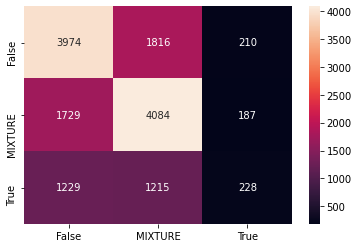


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.57      0.66      0.61      6000
     MIXTURE       0.57      0.68      0.62      6000
        True       0.36      0.09      0.14      2672

    accuracy                           0.56     14672
   macro avg       0.50      0.48      0.46     14672
weighted avg       0.54      0.56      0.53     14672



In [256]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(n_jobs=-1)
pipeline = get_pipeline(classifier)

data = df['text']
target = df['ratingName'].astype('string')

result = apply_classifier(pipeline, data, target, True)

Tout fonctionne, mais ne nous réjouissons pas trop vite, car notre précision est pas fameuse, $\approx56.5\%$, outre ça, la matrice de confusion laisse paraître un problème sur la colonne True. Cette colonne obtient des résultats passable face à Mixture et False avec des chiffres bien plus amaigris que ces concurrents. On se rend compte dans le rapport de classification que le *support* est deux à trois fois plus petits que les autres. Ceci est sûrement dû à un déséquilibre dans nos données, vérifions ça.

## Equilibrage dans le dataset

L'équilibrage des donnée permet de s'assurer que notre classifieur ne soit pas biaisé dans ses choix de réponse. Prenons le cas où plus de $\frac{3}{4}$ des informations sont fausses et seulement $\frac{1}{4}$ sont vraies. Après son apprentissage, le classifieur tendras facilement à dire qu'une assertion est fausse car il n'auras pas assez d'informations pour discerner correctement celles qui sont vraies. C'est ce qu'on appelle des faux négatif. Voilà pourquoi l'équilibrage est très important.

Jetons un coup d'œil dans notre dataframe.

In [257]:
def display_pie(dataframe, column_name, title=''):
  """
  Display a specific column in a pie chart
  @param dataframe, the dataframe.
  @param column_name, the column name to display
  @param title, the title of the pie, by default is empty
  """
  dataframe[column_name].value_counts().plot(
      kind='pie', 
      figsize=(6,10),
      title=title, 
      fontsize=11, 
      legend=True,
      shadow=True,
      autopct='%1.1f%%'
  )
  plt.show()

### Répartition général

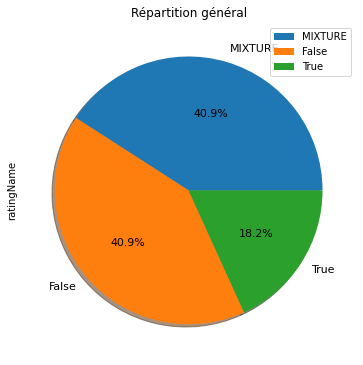

Statistique:
MIXTURE    10000
False      10000
True        4452
Name: ratingName, dtype: int64


In [258]:
display_pie(df, 'ratingName', 'Répartition général')

print("Statistique:")
print(df["ratingName"].value_counts())

Nous manquons cruellement de classe *True*, ce que nous avions supposées via la matrice de confusion est donc correcte. Nos *Mixture* étant assez proche de notre classe dominante cela explique la similirétude des résultats.

Dans le cadre du projet nous devrons nous intéresser aux tâches suivantes:
1. {True} vs {False}
2. ({True} || {False}) vs {Mixture}
3. {True} vs {False} vs {Mixture}

Visualisons la répartition des deux premières, la dernière ayant été vus ci-dessus.

### Répartition True et False

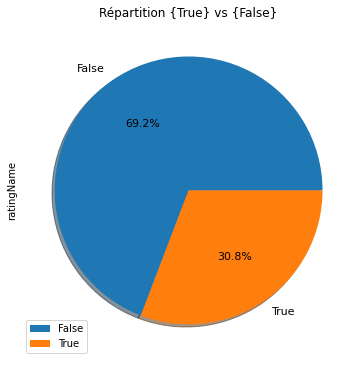

Statistique:
False    10000
True      4452
Name: ratingName, dtype: int64 




In [259]:
df_TF = df[df.truthRating != 2]
display_pie(df_TF, 'ratingName', 'Répartition {True} vs {False}')

print("Statistique:")
print(df_TF["ratingName"].value_counts(), '\n\n')

### Répartition False et Mixture

Nous l'expliquerons plus tard, mais les méthodes de rééquilibrage peuvent provoquer de la perte de donnée ou même les fausser, c'est pourquoi ici nous choisirons d'utiliser la classe *False*, car c'est celle qui possèdent autant de données.

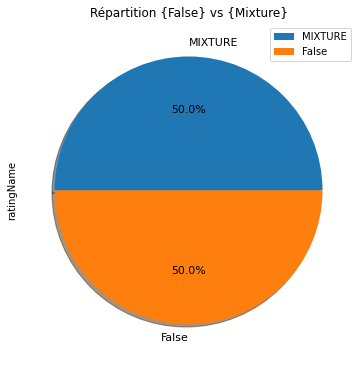

Statistique:
MIXTURE    10000
False      10000
Name: ratingName, dtype: int64


In [260]:
df_FM = df[df.truthRating != 3]
display_pie(df_FM, 'ratingName', 'Répartition {False} vs {Mixture}')

print("Statistique:")
print(df_FM["ratingName"].value_counts())

Pour rééquilibrer un jeu de donnée il existe de multiples méthodes mais nous allons en traiter deux ici:
1. Downslamping
2. Upslamping

En les utilisant nous pourront déterminer laquelle sera le plus optimal. 

C'est partis ! Tout d'abord divisons nos différentes classes en trois dataframe distinct.

In [261]:
nb_false, nb_mixture, nb_true = df["truthRating"].value_counts()

df_false = df[df['truthRating'] == 1]
df_mixture = df[df['truthRating'] == 2]
df_true = df[df['truthRating'] == 3]

### Précision avant sampling

# --- Application du classifieur 
[~] Fit réalisé en 0.228s
[~] Prédiction réalisée en 0.106s

[+] Accuracy: 71.218%

[~] Matrice de confusion:


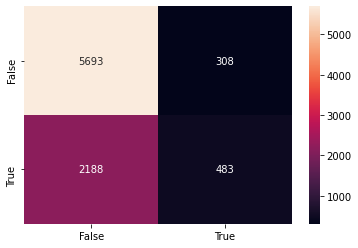


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.72      0.95      0.82      6001
        True       0.61      0.18      0.28      2671

    accuracy                           0.71      8672
   macro avg       0.67      0.56      0.55      8672
weighted avg       0.69      0.71      0.65      8672



In [262]:
data = df_TF['text']
target = df_TF['ratingName'].astype('string')

before_sampling = apply_classifier(pipeline, data, target, True)

### DownSlamping

La méthode de DownSlamping (ou sous-échantillonnage) processus de réduction de la fréquence d'échantillonnage. Ici c'est la réduction du nombre de données de la classe au nombre le plus élevée pour avoir le même nombre que la classe au nombre le plus faible.

Ici, avec True vs False, nous devrons donc réduire le nombre de classe False, pour se mettre à l'échelle du nombres de classe True. 

Voilà pourquoi précédemment nous parlions de perte de données, ici la classe False va en perdre, quasiment, deux tiers.

Répartition après DownSlamping:
True     4452
False    4452
Name: ratingName, dtype: int64 



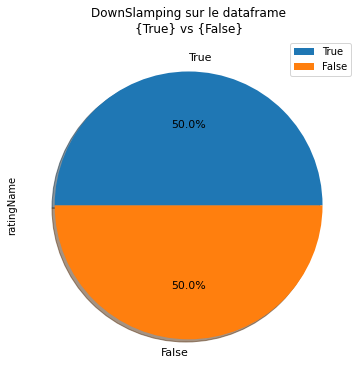

In [263]:
df_false_down = df_false.sample(nb_true)
df_TF_DOWN = pandas.concat([df_false_down, df_true], axis=0)

print('Répartition après DownSlamping:')
print(df_TF_DOWN["ratingName"].value_counts(), '\n')
display_pie(df_TF_DOWN, 'ratingName', 'DownSlamping sur le dataframe\n{True} vs {False}')

Le jeu de donnée à était parfaitement équilibrée par rapport à notre classe True, testons notre classifieur sur ce nouveau jeu de donnée équilibrée.

# --- Application du classifieur 
[~] Fit réalisé en 0.146s
[~] Prédiction réalisée en 0.072s

[+] Accuracy: 62.680%

[~] Matrice de confusion:


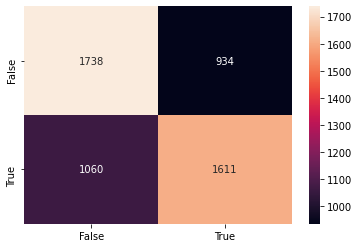


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.62      0.65      0.64      2672
        True       0.63      0.60      0.62      2671

    accuracy                           0.63      5343
   macro avg       0.63      0.63      0.63      5343
weighted avg       0.63      0.63      0.63      5343



0.6268014224218604

In [264]:
data = df_TF_DOWN['text']
target = df_TF_DOWN['ratingName'].astype('string')

apply_classifier(pipeline, data, target, True)

Comme prévus, suite à la perte des données la précision est bien plus faible qu'auparavant. Néanmoins la matrice de confusion est bien plus stable voir équivalente ce qui est plus acceptable.

### UpSlamping

La méthode de UpSlamping (ou sur-échantillonnage) est l'inverse du DownSlampling, son processus à pour but d'augmenter la fréquence d'échantillonnage.

Ce qui veut dire qu'avec True vs False, nous devrons donc augmenter le nombre de classe True, pour s'ajuster au nombre de classe False. 

A l'inverse de la perte de données, c'est les données aléatoires qui sont créent pendant l'opération qui peuvent poser problème et fausser notre prédiction.

Répartition après Upslamping:
True     10000
False    10000
Name: ratingName, dtype: int64 



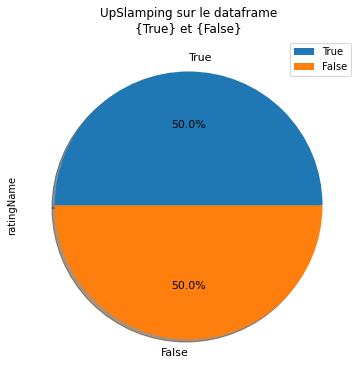

In [265]:
df_true_up = df_true.sample(nb_false, replace=True)
df_TF_UP = pandas.concat([df_false, df_true_up], axis=0)

print('Répartition après Upslamping:')
print(df_TF_UP["ratingName"].value_counts(), '\n')
display_pie(df_TF_UP, 'ratingName', 'UpSlamping sur le dataframe\n{True} et {False}')

Le jeu de donnée à était parfaitement équilibrée par rapport à notre classe False, testons notre classifieur sur ce nouveau jeu de donnée équilibrée.

# --- Application du classifieur 
[~] Fit réalisé en 0.545s
[~] Prédiction réalisée en 0.179s

[+] Accuracy: 71.567%

[~] Matrice de confusion:


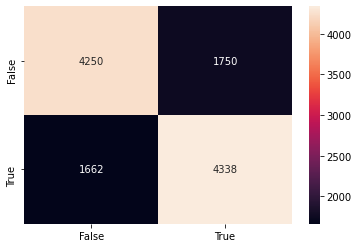


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.72      0.71      0.71      6000
        True       0.71      0.72      0.72      6000

    accuracy                           0.72     12000
   macro avg       0.72      0.72      0.72     12000
weighted avg       0.72      0.72      0.72     12000



In [266]:
data = df_TF_UP['text']
target = df_TF_UP['ratingName'].astype('string')

after_upsampling = apply_classifier(pipeline, data, target, True)

Comme prévus, la précision est nettement plus élevé mais la matrice de confusion montre bien le désavatange de cette méthode. Le nombre de True positif est légèrement supérieur aux Faux positifs, alors qu'au départ c'était l'inverse. Malgré tout cette méthode reste très performante et offre un résultat très convenable, nous l'adopterons donc dans la poursuite de notre étude.

## Avant de poursuivre

Avant de poursuivre plus loin, nous allons Upsampler les différentes formes que nous devons étudier par la suite, à savoir (*True vs False vs Mixture*) et (*False vs Mixture*). Au final nous n'avons que (*True vs False vs Mixture*) à faire car False et Mixture possèdent le même nombres de données.

### Upsampling True vs False vs Mixture

Répartition après Upslamping:
MIXTURE    10000
True       10000
False      10000
Name: ratingName, dtype: int64 



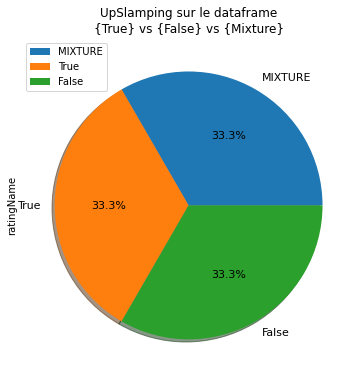

In [267]:
df_true_up = df_true.sample(nb_false, replace=True)
df_TFM_UP = pandas.concat([df_false, df_mixture, df_true_up], axis=0)

print('Répartition après Upslamping:')
print(df_TFM_UP["ratingName"].value_counts(), '\n')
display_pie(df_TFM_UP, 'ratingName', 'UpSlamping sur le dataframe\n{True} vs {False} vs {Mixture}')

## Avant de continuer

Petit topo de la situation. Nous avons prétraitées nos données pour les rendre plus efficaces lors de l'apprentissage de notre classifieur. Nous nous sommes assurés de rééquilibrer nos données correctement afin d'éviter la biaisage de notre modèle et nous venons de trouver les 2 classifieurs les plus aptes à continuer l'aventure. Il est temps d'optimiser notre modèle en injectant des données supplémentaires et choisir au mieux nos features.

# 4 - Optimisation

Pour améliorer notre précision nous pouvons ajouter de nouvelles features lors de l'apprentissage, mais il faut les choisirs avec soin. En effet, de nouvelles données inutiles ajouterait du bruit à l'estimation, de même si l'on ajoute des informations redondante. Nous pouvons ainsi économiser du temps et/ou de l'argent en ne mesurant pas ces prédicteurs.

### Initialisation et mise en place

In [268]:
def concat_features(df, features):
  """
  Concatène les différentes features
  @param df, the dataframe
  @param features, the features to concatenate
  @return the features concatenate
  """

  data = df[features]
  return data.apply(
      lambda x: ' '.join(x.dropna().astype(str)),
      axis=1
  )

### Remove constant and select best features

Nous pouvons améliorer les features a faible variances en supprimant toutes les features inférieure à une certaines valeurs données. Après cette étape de nettoyage on peut utiliser un selecteur de feature qui choisis, ici, la moitié des features en fonction de leur poids.

In [317]:
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

TFIDF_VECT = TfidfVectorizer(min_df=0.001, ngram_range=(1,3))
VT = VarianceThreshold(threshold=0.0002)
SFM = SelectFromModel(LogisticRegression())

def get_pipeline_improved(classifier):
  """
  Get the pipeline for a classifier with an additional variance threshold
  @param classifier, the classifier to use.
  """
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('feature_selection', SFM),
                   ('clf', classifier)])

# --- Application du classifieur 
[~] Fit réalisé en 0.996s
[~] Prédiction réalisée en 0.331s

[+] Accuracy: 68.050%

[~] Matrice de confusion:


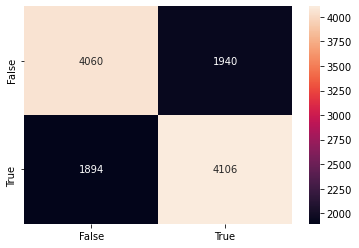


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.68      0.68      0.68      6000
        True       0.68      0.68      0.68      6000

    accuracy                           0.68     12000
   macro avg       0.68      0.68      0.68     12000
weighted avg       0.68      0.68      0.68     12000

[+] Feature selection accuracy: 68.05%


In [270]:
pipeline = get_pipeline_improved(classifier)
feature_selection_accuracy = apply_classifier(pipeline, data, target, True)

print("[+] Feature selection accuracy: %0.2f%%" 
      %to_percent(feature_selection_accuracy))

Les résultats sont moins bons que précédemment, vérifions que ceci n'est pas dû à notre classifieur en testant avec un autre comme RandomForest (RF) par exemple.

# --- Application du classifieur 
[~] Fit réalisé en 5.616s
[~] Prédiction réalisée en 1.164s

[+] Accuracy: 75.217%

[~] Matrice de confusion:


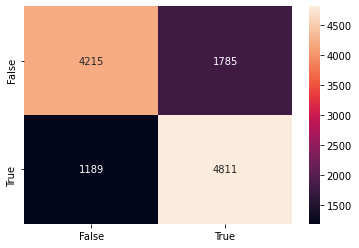


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.78      0.70      0.74      6000
        True       0.73      0.80      0.76      6000

    accuracy                           0.75     12000
   macro avg       0.75      0.75      0.75     12000
weighted avg       0.75      0.75      0.75     12000

[+] Feature selection accuracy: 75.22%


In [271]:
from sklearn.ensemble import RandomForestClassifier
RF_pipeline = get_pipeline_improved(RandomForestClassifier())
feature_selection_accuracy = apply_classifier(RF_pipeline, data, target, True)

print("[+] Feature selection accuracy: %0.2f%%" 
      %to_percent(feature_selection_accuracy))

Le temps de calcul à était augmentée de 4s dû à ce nouveau classifieur mais nous gagnons $\approx4\%$ de précision ce qui n'est pas négligeable. 

## Ajouts de données additionnelles

Listons nos données additionnelles disponible:
* date
* author
* headline
* named_entities_claim
* named_entities_article
* keywords
* source
* sourceURL
* link
* language

La date n'est pas un élément utile, composé uniquement de chiffre elle n'apportera aucune information et ne sera que du bruit dans notre apprentissage. 

In [272]:
unwanted = ['date']

Les liens relatifs et absolus, respectivement *sourceURL* et *link* sont aussi des sources de bruits qui sont généralement supprimé lors du prétraitement du texte, donc les ajouter n'est pas correcte. 

In [273]:
unwanted.extend(['sourceURL', 'link'])

Le colonne *Language* est inutile dans le sens ou les données qui la composent est redondante. Composé entièrement de la même valeur, ici "English". Les données comme celles-ci sont inutiles pour améliorer les prédictions.

In [274]:
unwanted.append('language')

In [275]:
_df = df_TF_UP.drop(unwanted, axis=1)
_df.head()

,text,author,headline,named_entities_claim,named_entities_article,keywords,source,truthRating,ratingName
0,hillari main extracurricular activ law school ...,chain email,help black panther,aclu alex rackley american civil liberties uni...,black panthers,candidate biography,politifact,1,False
1,say hillari clinton plan would bring refuge fi...,donald trump,trump say clinton would bring refuge first term,barack obama cbs center global development cou...,hillary clinton,immigration,politifact,1,False
2,canada suffer major donut shortag short countr...,unknown,canadian face major donut shortag first day ca...,cnn daily bonnet girl scout cookies tim horton...,marijuana,canada marijuana world news daily report,snopes,1,False
3,mayor ath belgium refus remov pork school cant...,unknown,belgian mayor refus ban pork school cafeteria,belgium islam maryborough victoria muslim queb...,,islam,snopes,1,False
4,say pete gallego cancel plan meet famili sandi...,roland gutierrez,roland gutierrez err say pete gallego cancel m...,mass shooting carlos uresti democrat facebook ...,pete gallego,congress guns,politifact,1,False


### Chacun son tour, ne vous bousculez pas !

Comparons le bénéfices de précision obtenus lors de l'ajout d'une unique feature, avec notre texte principal, nous pourrons ainsi déterminer des conclusions sur notre méthodes de choix.

In [278]:
features = list(_df.columns)[:-2]
accuracies = []

for feature in features[1:]:
  actual_features = ['text', feature]
  data = concat_features(_df, actual_features)
  accuracy = apply_classifier(RF_pipeline, data, target)
  print("Features:", actual_features, 
        "| Accuracy: %0.2f%%" % to_percent(accuracy))
  accuracies.append(accuracy)

Features: ['text', 'author'] | Accuracy: 76.56%
Features: ['text', 'headline'] | Accuracy: 76.55%
Features: ['text', 'named_entities_claim'] | Accuracy: 77.68%
Features: ['text', 'named_entities_article'] | Accuracy: 75.26%
Features: ['text', 'keywords'] | Accuracy: 76.90%
Features: ['text', 'source'] | Accuracy: 76.35%


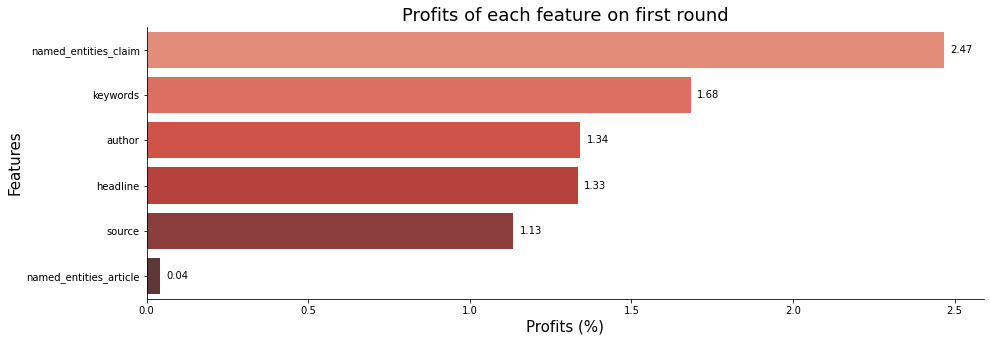

In [279]:
profits = [to_percent(accuracy - feature_selection_accuracy) for accuracy in accuracies]

# mise à l'échelle si nécessaire
# min = np.min(profits)
# if (min < 0): profits = list(map(lambda x: x + abs(min), profits))

df_profits = pandas.DataFrame({
    'features': features[1:], 
    'profits': profits})
df_profits = df_profits.sort_values(by='profits', ascending=False)

display_barplot(df_profits, 
                "Profits of each feature on first round", 
                'profits', 
                'Profits (%)',
                'features', 
                'Features', 
                'h')

Toutes les données sembles utiles à ajouter. Sauf named_entities_article qui est très faible et author car on le rappelle celui-ci appartient déjà à named_entities_claim

In [286]:
features = ['text', 'named_entities_claim', 'headline', 'keywords', 'source']

### Précision avec les nouvelles données

[+] Features: ['text', 'named_entities_claim', 'headline', 'keywords', 'source'] 

# --- Application du classifieur 
[~] Fit réalisé en 10.869s
[~] Prédiction réalisée en 2.313s

[+] Accuracy: 80.408%

[~] Matrice de confusion:


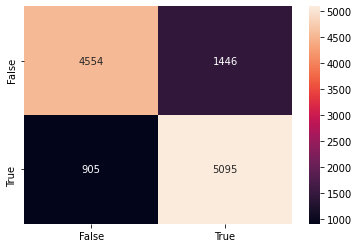


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.83      0.76      0.79      6000
        True       0.78      0.85      0.81      6000

    accuracy                           0.80     12000
   macro avg       0.81      0.80      0.80     12000
weighted avg       0.81      0.80      0.80     12000



In [288]:
print("[+] Features:", features, "\n")

data = concat_features(_df, features)
TF_accuracy = apply_classifier(RF_pipeline, data, target, True)

Avec toutes les données nous obtenons un score avoisinant les $80.4\%$ soit $\approx5\%$ de plus que notre score précédent.

## Benchmark

Il existe de multiples classifieurs, nous allons donc effectuer un benchmark de certains d'entre eux sur nos données afin de déterminer le plus amême de nous founir les meilleurs performances. Nous conserverons ces résultats et ses paramètres pour la suite du projet.

### Initialisation des fonctions et des classifieurs

In [294]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

SEED = 42
models = ['RandomForest', 'KNeighbors', 'SGD', 'LogisticRegression']

classifiers = {
    models[0]: RandomForestClassifier(random_state=SEED, n_jobs=-1), 
    models[1]: KNeighborsClassifier(n_jobs=-1), 
    models[2]: SGDClassifier(random_state=SEED, n_jobs=-1),
    models[3]: LogisticRegression(random_state=SEED, n_jobs=-1)
}

params = {
  models[0]: {
      'clf__min_samples_split': [1, 2, 3],
      'clf__min_samples_leaf': [1, 2, 3],
      'clf__n_estimators': [100, 200, 300],
      'clf__criterion': ['gini', 'entropy']
  },
  models[1]: {
      'clf__n_neighbors': [5, 10], 
      'clf__weights': ['uniform', 'distance'], 
      'clf__leaf_size': [2, 5]
  },
  models[2]: {
      'clf__max_iter': [500, 1000, 2000],
      'clf__penalty': ['l1', 'l2', 'elasticnet']
  },
  models[3]: {
      'clf__max_iter': [1000, 2500, 5000],
      'clf__C': [1, 2], 
      'clf__solver' : ['lbfgs', 'liblinear']
  }
}

Nos classifieurs et leur différents paramètres sont en place, il ne nous reste plus qu'à ajouter une fonction permettant d'itérer sur nos différents modèles pour les tester un a un et renvoyer le meilleur d'entre eux.

In [297]:
from sklearn.model_selection import GridSearchCV 

def init_grid_search(pipeline, params):
  """
  Initialize a GridSearchCV
  @param pipeline: (Pipeline) The pipeline
  @params params: (object) The pipeline params
  @return GridSearchCV: (GridSearchCV) The GridSearch
  """
  return GridSearchCV(pipeline, params, scoring='accuracy', n_jobs=-1)

def apply_grid(grid, X_train, X_test, y_train, y_test, 
               disp=False, classifier_name=''):
  """
  Apply the grid on the dataset give
  @param grid: (GridSearchCV) The grid
  @params X_train: (array) The data
  @params X_test: (array) The data to test
  @params y_train: (array) The target
  @params y_test: (array) The target to test
  @params disp: (bool) Toggle print display, default is False
  @params classifier_name: (string) Name of the classifier, default is empty
  @return [accuracy, params]: (array) The best accuracy and best params found
  """

  # --- Mise en place du GridSearch
  if disp: print("# --- Application du classifieur", classifier_name)

  # --- Fit
  t0 = time()
  grid.fit(X_train, y_train)
  if disp: print("[~] Fit réalisé en %0.3fs" % (time() - t0))

  # --- Predict
  t0 = time()
  result = grid.predict(X_test)
  if disp: print("[~] Prédiction réalisée en %0.3fs\n" % (time() - t0))

  # --- Accuracy
  accuracy = accuracy_score(y_test, result)
  best_params = grid.best_params_
  print('[+] Accuracy: %0.3f%%' % to_percent(accuracy))
  print("[+] Meilleurs paramètres: ", best_params)
  
  # --- Confusion Matrix
  conf = confusion_matrix(y_test, result)
  if disp: 
    print('\n[~] Matrice de confusion:')
    labels = np.unique(y_test)
    display_confusion_matrix(conf, labels)

  # --- Report
  if disp: 
    print('\n[~] Rapport de classification: \n', classification_report(y_test, 
                                                                       result))
  return [accuracy, best_params]


def get_best_classifier(models, classifiers, params, data, target, disp):
  """
  Test all classifiers and return the best one.
  """
  # --- Mise en place du jeu de test
  validation_size = 0.4
  testsize= 1 - validation_size
  X_train, X_test, y_train, y_test = train_test_split(
      data, 
      target, 
      train_size=validation_size, 
      test_size=testsize,
      random_state=SEED,
      stratify=target
  )

  best_model = ''
  best_accuracy = 0.0
  best_params = {}

  for model in models:
    pipeline = get_pipeline_improved(classifiers[model])
    grid = init_grid_search(pipeline, params[model])
    result = apply_grid(grid, X_train, X_test, y_train, y_test, disp, model)

    if (result[0] > best_accuracy):
      best_model = model
      best_accuracy = result[0]
      best_params = result[1]

  return [best_model, best_accuracy, best_params]

### Exécution (Optionnel)

Tout est prêt nous pouvons démarrer le benchmark, ce processus pouvant être très long nous vous conseillons d'avoir un thé ou café auprès de vous si vous venez à l'exécuter ☕.

# --- Application du classifieur RandomForest
[~] Fit réalisé en 1779.648s
[~] Prédiction réalisée en 2.617s

[+] Accuracy: 80.433%
[+] Meilleurs paramètres:  {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3, 'clf__n_estimators': 300}

[~] Matrice de confusion:


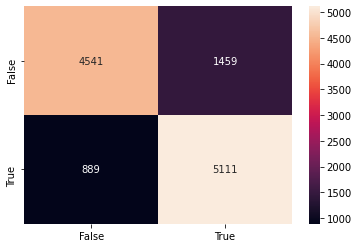


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.84      0.76      0.79      6000
        True       0.78      0.85      0.81      6000

    accuracy                           0.80     12000
   macro avg       0.81      0.80      0.80     12000
weighted avg       0.81      0.80      0.80     12000

# --- Application du classifieur KNeighbors


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[~] Fit réalisé en 106.931s
[~] Prédiction réalisée en 10.699s

[+] Accuracy: 79.500%
[+] Meilleurs paramètres:  {'clf__leaf_size': 2, 'clf__n_neighbors': 10, 'clf__weights': 'distance'}

[~] Matrice de confusion:


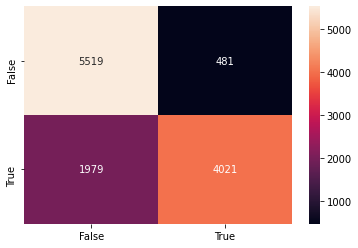


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.74      0.92      0.82      6000
        True       0.89      0.67      0.77      6000

    accuracy                           0.80     12000
   macro avg       0.81      0.79      0.79     12000
weighted avg       0.81      0.80      0.79     12000

# --- Application du classifieur SGD
[~] Fit réalisé en 102.990s
[~] Prédiction réalisée en 1.552s

[+] Accuracy: 75.683%
[+] Meilleurs paramètres:  {'clf__max_iter': 500, 'clf__penalty': 'elasticnet'}

[~] Matrice de confusion:


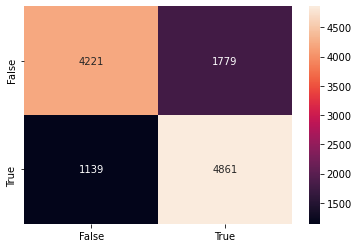


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.79      0.70      0.74      6000
        True       0.73      0.81      0.77      6000

    accuracy                           0.76     12000
   macro avg       0.76      0.76      0.76     12000
weighted avg       0.76      0.76      0.76     12000

# --- Application du classifieur LogisticRegression
[~] Fit réalisé en 143.168s
[~] Prédiction réalisée en 1.662s

[+] Accuracy: 75.575%
[+] Meilleurs paramètres:  {'clf__C': 2, 'clf__max_iter': 1000, 'clf__solver': 'lbfgs'}

[~] Matrice de confusion:


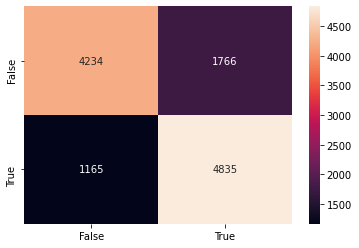


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.78      0.71      0.74      6000
        True       0.73      0.81      0.77      6000

    accuracy                           0.76     12000
   macro avg       0.76      0.76      0.76     12000
weighted avg       0.76      0.76      0.76     12000


--------------------------------------------------------------------- 
[+] Meilleur classifieur: RandomForest 
[+] Accuracy: 80.433% 
[+] Params:  {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3, 'clf__n_estimators': 300}


In [296]:
data = concat_features(_df, features)
target = _df['ratingName'].astype('string')

result = get_best_classifier(models, classifiers, params, data, target, True)

print("\n---------------------------------------------------------------------",
      "\n[+] Meilleur classifieur:", result[0], 
      "\n[+] Accuracy: %0.3f%%" % to_percent(result[1]),
      "\n[+] Params: ", result[2])

Le classifier RandomForest (RF) qui arrive en tête avec un taux de précision avoisinnant les $\approx80.2\%$, talonné par LogisticRegression (LR) avec près de $\approx78.9\%$. Nous avons donc encore réussi à améliorer notre modèles.

### Sauvegarde

Sauvegardons nos deux meilleurs résultat pour éviter de réexécuter notre benchmark à chaque fois. Nous conservons les deux premiers au cas ou par la suite nous souhaiterions encore une fois les comparer.

In [302]:
# --- Save the best accuracy found
best_clf_accuracy = result[1]

In [300]:
# --- Best classifier
best_clf_name = "RandomForest"
best_clf = classifiers[best_clf_name]

params = {'criterion': 'entropy', 
          'min_samples_leaf': 1, 'min_samples_split': 3, 
          'n_estimators': 300}
best_clf.set_params(**params)

best_clf_pipeline = get_pipeline_improved(best_clf)
print("[+] Best classifier: \n", best_clf)

# --- Second best classifier
LR_name = "LogisticRegression"
LR_clf = classifiers[LR_name]

params = {'C': 2, 'max_iter': 1000, 'solver': 'lbfgs'}
LR_clf.set_params(**params)

LR_pipeline = get_pipeline_improved(LR_clf)
print("[+] Second best classifier: \n", LR_clf)

[+] Best classifier: 
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
[+] Second best classifier: 
 LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


### Conclusion

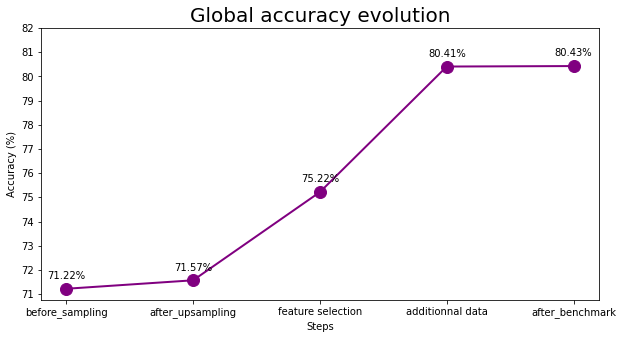

In [306]:
x = ["before_sampling", "after_upsampling", 
     "feature selection", 
     "additionnal data",
     "after_benchmark"]

y = [to_percent(before_sampling), to_percent(after_upsampling),
     to_percent(feature_selection_accuracy),
     to_percent(TF_accuracy),
     to_percent(best_clf_accuracy)]
y = list(map(lambda x: round(x, 2), y))

# --- Plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(x, y,
         marker='o', markersize=12,
         linewidth=2, color='purple')

# --- Cosmetic
plt.title(label='Global accuracy evolution', fontsize=20)
plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')

# --- Labels on marker
for a,b in zip(x, y): 
  plt.text(a, b+0.4, str(b)+"%", ha="center")

# --- Ticks
yticks_min = round(np.amin(y))
yticks_max = round(np.amax(y))+3
plt.yticks(np.arange(yticks_min, yticks_max, 1))

plt.show()

In [ ]:
print("Bénéfices global: +%0.2f%%" %to_percent(best_clf_accuracy - before_sampling))

Bénéfices global: +8.97%


## Faux vs Mixture

In [318]:
_df = df_FM.drop(unwanted, axis=1)
_df.head()

,text,author,headline,named_entities_claim,named_entities_article,keywords,source,truthRating,ratingName
0,hillari main extracurricular activ law school ...,chain email,help black panther,aclu alex rackley american civil liberties uni...,black panthers,candidate biography,politifact,1,False
1,say hillari clinton plan would bring refuge fi...,donald trump,trump say clinton would bring refuge first term,barack obama cbs center global development cou...,hillary clinton,immigration,politifact,1,False
2,canada suffer major donut shortag short countr...,unknown,canadian face major donut shortag first day ca...,cnn daily bonnet girl scout cookies tim horton...,marijuana,canada marijuana world news daily report,snopes,1,False
3,mayor ath belgium refus remov pork school cant...,unknown,belgian mayor refus ban pork school cafeteria,belgium islam maryborough victoria muslim queb...,,islam,snopes,1,False
4,say pete gallego cancel plan meet famili sandi...,roland gutierrez,roland gutierrez err say pete gallego cancel m...,mass shooting carlos uresti democrat facebook ...,pete gallego,congress guns,politifact,1,False


In [319]:
def display_unique_data_profits(df, classifier, features, target):
  
  witness_acc = apply_classifier(classifier, df['text'], target)
  print("Witness accuracy: %0.2f%%" % to_percent(witness_acc))

  accuracies = []

  # --- get profits
  for feature in features:
    actual_features = ['text', feature]
    data = concat_features(_df, actual_features)
    accuracy = apply_classifier(classifier, data, target)
    print("Features:", actual_features, 
          "| Accuracy: %0.2f%%" % to_percent(accuracy))
    accuracies.append(accuracy)
    
  profits = [to_percent(accuracy - witness_acc) for accuracy in accuracies]
  
  # --- store and order in a dataframe
  df_profits = pandas.DataFrame({
    'features': features, 
    'profits': profits})
  df_profits = df_profits.sort_values(by='profits', ascending=False)

  # --- display them
  display_barplot(df_profits, 
                  "Profits of each feature on first round", 
                  'profits', 
                  'Profits (%)',
                  'features', 
                  'Features', 
                  'h')

Witness accuracy: 66.58%
Features: ['text', 'author'] | Accuracy: 72.45%
Features: ['text', 'headline'] | Accuracy: 70.76%
Features: ['text', 'named_entities_claim'] | Accuracy: 73.83%
Features: ['text', 'named_entities_article'] | Accuracy: 66.30%
Features: ['text', 'keywords'] | Accuracy: 71.32%
Features: ['text', 'source'] | Accuracy: 70.41%


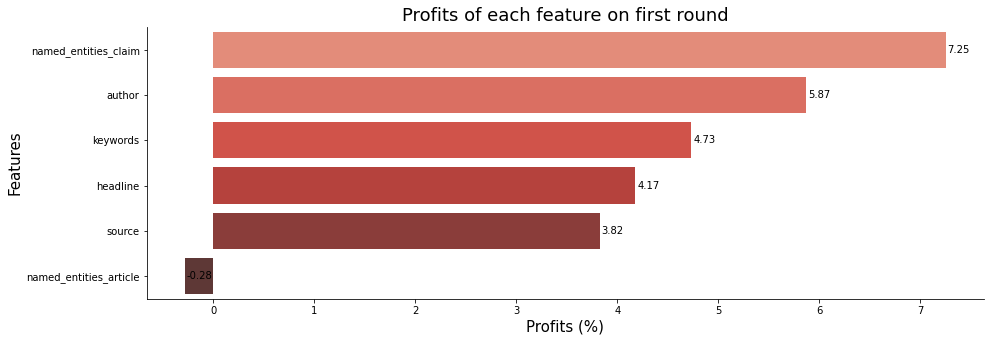

In [320]:
additionnal_features = list(_df.columns)[1:-2]
target = _df['ratingName'].astype('string')
display_unique_data_profits(_df, best_clf_pipeline, additionnal_features, target)

Witness accuracy: 68.60%
Features: ['text', 'author'] | Accuracy: 72.80%
Features: ['text', 'headline'] | Accuracy: 70.97%
Features: ['text', 'named_entities_claim'] | Accuracy: 73.32%
Features: ['text', 'named_entities_article'] | Accuracy: 68.76%
Features: ['text', 'keywords'] | Accuracy: 72.19%
Features: ['text', 'source'] | Accuracy: 70.82%


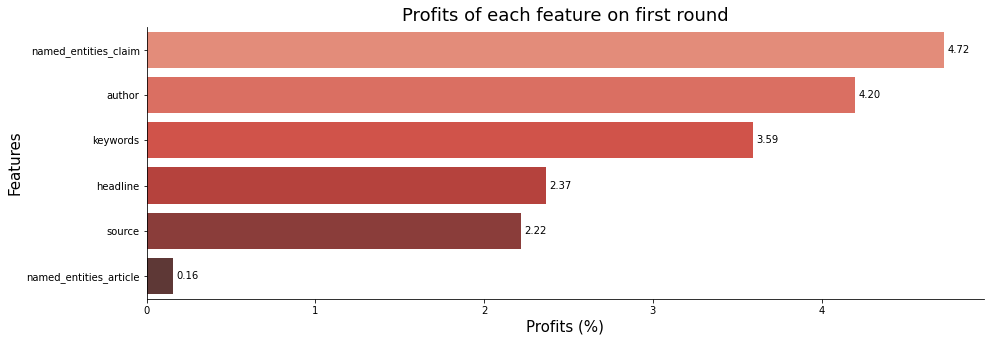

In [321]:
display_unique_data_profits(_df, LR_pipeline, additionnal_features, target)

Même constat que pour True vs False

In [322]:
features = ['text', 'named_entities_claim', 'headline', 'keywords', 'source']

# --- Application du classifieur 
[~] Fit réalisé en 19.261s
[~] Prédiction réalisée en 2.722s

[+] Accuracy: 75.492%

[~] Matrice de confusion:


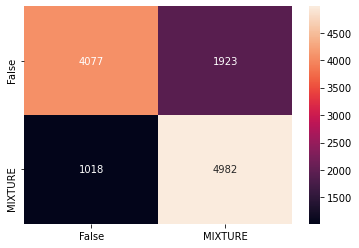


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.80      0.68      0.73      6000
     MIXTURE       0.72      0.83      0.77      6000

    accuracy                           0.75     12000
   macro avg       0.76      0.75      0.75     12000
weighted avg       0.76      0.75      0.75     12000



In [323]:
data = concat_features(_df, features)
FM_accuracy = apply_classifier(best_clf_pipeline, data, target, True)

## True vs False vs Mixture

In [324]:
_df = df_TFM_UP.drop(unwanted, axis=1)
_df.head()

,text,author,headline,named_entities_claim,named_entities_article,keywords,source,truthRating,ratingName
0,hillari main extracurricular activ law school ...,chain email,help black panther,aclu alex rackley american civil liberties uni...,black panthers,candidate biography,politifact,1,False
1,say hillari clinton plan would bring refuge fi...,donald trump,trump say clinton would bring refuge first term,barack obama cbs center global development cou...,hillary clinton,immigration,politifact,1,False
2,canada suffer major donut shortag short countr...,unknown,canadian face major donut shortag first day ca...,cnn daily bonnet girl scout cookies tim horton...,marijuana,canada marijuana world news daily report,snopes,1,False
3,mayor ath belgium refus remov pork school cant...,unknown,belgian mayor refus ban pork school cafeteria,belgium islam maryborough victoria muslim queb...,,islam,snopes,1,False
4,say pete gallego cancel plan meet famili sandi...,roland gutierrez,roland gutierrez err say pete gallego cancel m...,mass shooting carlos uresti democrat facebook ...,pete gallego,congress guns,politifact,1,False


In [332]:
def get_pipeline_improved_bis(classifier):
  """
  Get the pipeline for a classifier with an additional variance threshold
  @param classifier, the classifier to use.
  """
  _SFM = SelectFromModel(best_clf)
  return Pipeline([('tfidf', TFIDF_VECT),
                   ('feature_selection', _SFM),
                   ('clf', classifier)])

Witness accuracy: 61.57%
Features: ['text', 'author'] | Accuracy: 65.91%
Features: ['text', 'headline'] | Accuracy: 65.31%
Features: ['text', 'named_entities_claim'] | Accuracy: 67.89%
Features: ['text', 'named_entities_article'] | Accuracy: 61.84%
Features: ['text', 'keywords'] | Accuracy: 65.67%
Features: ['text', 'source'] | Accuracy: 64.68%


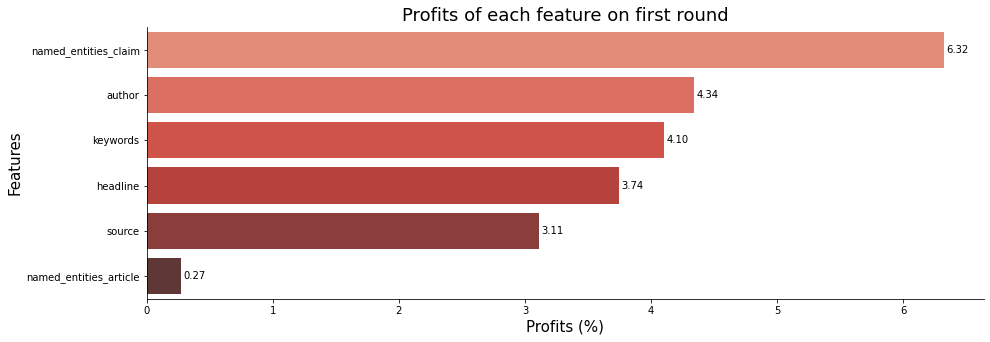

In [333]:
_pipeline = get_pipeline_improved_bis(best_clf)
target = _df['ratingName'].astype('string')
display_unique_data_profits(_df, _pipeline, additionnal_features, target)

# --- Application du classifieur 
[~] Fit réalisé en 90.107s
[~] Prédiction réalisée en 4.022s

[+] Accuracy: 69.850%

[~] Matrice de confusion:


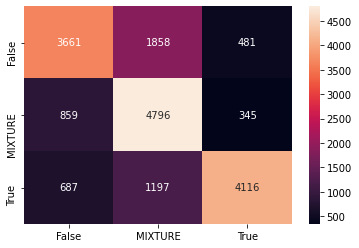


[~] Rapport de classification: 
               precision    recall  f1-score   support

       False       0.70      0.61      0.65      6000
     MIXTURE       0.61      0.80      0.69      6000
        True       0.83      0.69      0.75      6000

    accuracy                           0.70     18000
   macro avg       0.72      0.70      0.70     18000
weighted avg       0.72      0.70      0.70     18000



In [335]:
features = ['text', 'named_entities_claim', 'headline', 'keywords', 'source']
data = concat_features(_df, features)
TFM_accuracy = apply_classifier(_pipeline, data, target, True)